In [2]:
#Input path
data_path = "/Users/jorditorresvallverdu/Library/Mobile Documents/com~apple~CloudDocs/tse/year2/term2/io_empirique/RUST.DAT" ##-->CHANGE JUST THIS PART MANUALLY!

#Output path
export_dir = "/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/" ##Change this manually too

"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/"

In [3]:
using DataFrames, CSV

df = CSV.read(
    data_path,
    DataFrame;
    delim=' ',
    ignorerepeated=true,
    header=false
)

rename!(df, [:mileage, :change])

Row,mileage,change
,Int64,Int64
1,140953,2
2,142960,0
3,145380,0
4,148140,0
5,150921,0
6,153839,0
7,155841,0
8,158063,0
9,160674,0


In [4]:
#Data cleaning 

using ShiftedArrays


df.mileage = df.mileage ./ 10000

df.bus_id = cumsum(df.change .== 2)

df = transform(
    groupby(df, :bus_id),
    :mileage => (x -> ShiftedArrays.lag(x, 1)) => :lag_mileage
)





Row,mileage,change,bus_id,lag_mileage
,Float64,Int64,Int64,Float64?
1,14.0953,2,1,missing
2,14.296,0,1,14.0953
3,14.538,0,1,14.296
4,14.814,0,1,14.538
5,15.0921,0,1,14.814
6,15.3839,0,1,15.0921
7,15.5841,0,1,15.3839
8,15.8063,0,1,15.5841
9,16.0674,0,1,15.8063


---
**Problem 1**


---

In [5]:
using GLM, RegressionTables

probit_dta = filter(row -> row.change != 2, df)
probit_dta.change = ifelse.(probit_dta.change .== 1, 1, 0)

probit_dta = filter(row -> !ismissing(row.lag_mileage), probit_dta) #drop first row


m1 = glm(@formula(change ~ lag_mileage),
         probit_dta, Binomial(), ProbitLink())


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

change ~ 1 + lag_mileage

Coefficients:
────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -3.32764   0.136366    -24.40    <1e-99  -3.59491    -3.06037
lag_mileage   0.062923  0.00688822    9.13    <1e-19   0.0494223   0.0764236
────────────────────────────────────────────────────────────────────────────

In [6]:
probit_dta

Row,mileage,change,bus_id,lag_mileage
,Float64,Int64,Int64,Float64?
1,14.296,0,1,14.0953
2,14.538,0,1,14.296
3,14.814,0,1,14.538
4,15.0921,0,1,14.814
5,15.3839,0,1,15.0921
6,15.5841,0,1,15.3839
7,15.8063,0,1,15.5841
8,16.0674,0,1,15.8063
9,16.2984,0,1,16.0674


In [5]:
#Alternative specifications 
probit_dta.mileage2= probit_dta.lag_mileage.^2
probit_dta.mileage3= probit_dta.lag_mileage.^3
probit_dta.log_mileage = log.(1 .+ probit_dta.lag_mileage)

m2 = glm(@formula(change ~ lag_mileage + mileage2 ),
                   probit_dta,
                   Binomial(),
                   ProbitLink())


m3 = glm(@formula(change ~ lag_mileage + mileage2 + mileage3 ),
                   probit_dta,
                   Binomial(),
                   ProbitLink())

m4 = glm(@formula(change ~ log_mileage),
                   probit_dta,
                   Binomial(),
                   ProbitLink())




 regtable(
    m1, 
    m2,
    m3,
    m4;
    renderSettings = LatexTable(),
    file = joinpath(export_dir, "ps2_probit_op.tex")
)



┌ Warning: renderSettings is deprecated. Specify render type with render=LatexTable() and file with file=/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/ps2_probit_op.tex
└ @ RegressionTables ~/.julia/packages/RegressionTables/wzLBu/src/regtable.jl:441


\begin{tabular}{lrrrr}
\toprule
             &           \multicolumn{4}{c}{change}          \\ 
\cmidrule(lr){2-5} 
             &       (1) &       (2) &       (3) &       (4) \\ 
\midrule
(Intercept)  & -3.328*** & -4.297*** & -6.652*** & -5.387*** \\ 
             &   (0.136) &   (0.419) &   (1.501) &   (0.429) \\ 
lag\_mileage &  0.063*** &  0.185*** &    0.608* &           \\ 
             &   (0.007) &   (0.046) &   (0.247) &           \\ 
mileage2     &           &  -0.003** &   -0.027* &           \\ 
             &           &   (0.001) &   (0.013) &           \\ 
mileage3     &           &           &     0.000 &           \\ 
             &           &           &   (0.000) &           \\ 
log\_mileage &           &           &           &  1.112*** \\ 
             &           &           &           &   (0.145) \\ 
\midrule
$N$          &     7,250 &     7,250 &     7,250 &     7,250 \\ 
Pseudo $R^2$ &     0.132 &     0.145 &     0.151 &     0.145 \\ 
\bottomrule
\end{tab

In [6]:
#comparing models ...

using StatsBase

models = Dict(
    "Linear"    => m1,
    "Quadratic" => m2,
    "Cubic"     => m3,
    "Log"       => m4
)

using DataFrames

aic_table = DataFrame(
    Model = String[],
    AIC = Float64[],
    BIC = Float64[]
)

for (name, m) in models
    push!(aic_table, (
        name,
        round(aic(m), digits=2),
        round(bic(m), digits=2)
    ))
end

show(stdout, MIME("text/latex"), aic_table)


\begin{tabular}{r|ccc}
	& Model & AIC & BIC\\
	\hline
	& String & Float64 & Float64\\
	\hline
	1 & Quadratic & 632.31 & 652.98 \\
	2 & Cubic & 629.98 & 657.54 \\
	3 & Log & 630.83 & 644.61 \\
	4 & Linear & 640.29 & 654.07 \\
\end{tabular}


14

In [7]:
#plot

using DataFrames, Plots, GLM, Distributions

grid = collect(range(0, 40, length=400))

new_data = DataFrame(lag_mileage = grid)
new_data.mileage2    = new_data.lag_mileage .^ 2
new_data.mileage3    = new_data.lag_mileage .^ 3
new_data.log_mileage = log.(1 .+ new_data.lag_mileage)

η1 = predict(m1, new_data)
η2 = predict(m2, new_data)
η3 = predict(m3, new_data)
η4 = predict(m4, new_data)



400-element Vector{Union{Missing, Float64}}:
 3.582067839722322e-8
 6.430914874065268e-8
 1.0866428571195721e-7
 1.7463327901165626e-7
 2.6908070080409973e-7
 4.000224643133711e-7
 5.766441534533143e-7
 8.093055979156326e-7
 1.1095335487303034e-6
 1.4900042177479488e-6
 1.9645173128702934e-6
 2.5479630502524315e-6
 3.256283468660537e-6
 ⋮
 0.09865443371174006
 0.09914006342313186
 0.09962621687802722
 0.10011288956592712
 0.10060007699540613
 0.10108777469407697
 0.10157597820855387
 0.1020646831044161
 0.10255388496617035
 0.10304357939721265
 0.10353376201978985
 0.10402442847496038

In [8]:
plot(grid, η1, label="Linear", xlabel="Mileage (10,000 miles)", ylabel="P(invest)", linewidth=2)
plot!(grid, η2, label="Quadratic", linewidth=2)
plot!(grid, η3, label="Cubic", linewidth=2)
plot!(grid, η4, label="Log", linewidth=2)

savefig(joinpath(export_dir, "ps1_probit_probabilities.pdf"))

"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/ps1_probit_probabilities.pdf"

---

**Question 2**

---

In [9]:
#Question 2
using ShiftedArrays, Statistics

df = transform(
    groupby(df, :bus_id), 
    :mileage => (x->lag(x,1)) => :lag_mileage
)
df.dif= df.mileage .- df.lag_mileage


df_valid = df[(df.change .== 0) .& .!ismissing.(df.lag_mileage), :]

mean_s = mean(df_valid.dif)
std_s  = std(df_valid.dif)

#oending to change this shit. IDK why the greek letters dont come up.

ps1_io_table_ex2 = DataFrame(
Parameter = ["ρ (mean increase)", "σ (std. dev.)"],
Values = [mean_s, std_s]
)

show(stdout, MIME("text/latex"), ps1_io_table_ex2)

     


\begin{tabular}{r|cc}
	& Parameter & Values\\
	\hline
	& String & Float64\\
	\hline
	1 & ρ (mean increase) & 0.190387 \\
	2 & σ (std. dev.) & 0.113453 \\
\end{tabular}


14

---

**Question 3**

---

In [10]:
#Create functions
using Base.MathConstants, Random


alpha= coef(m4)[1]
beta= coef(m4)[2]

#policy function
function p(s)
    eta= alpha + beta * log(1+s)
    p = cdf.(Normal(), eta)
    return p
end 

#fixed parameters
const β= 0.99

const T=100
const K=10

const γ = eulergamma


#from q2 we have epsilon~N(rho, sigma^p)
const rho=mean_s
const sigma=std_s

# Set seed for replicability and staibility of results
Random.seed!(1234)

TaskLocalRNG()

In [11]:
function x(s0, invest::Bool)

    k_vec_1 = zeros(K)
    k_vec_2 = zeros(K)
    k_vec_3 = zeros(K)

    for k in 1:K

        if invest
            s = s0
        else
            s = s0 + rand(Normal(rho, sigma))
        end

        for τ in 1:T

            prob = p(s)
            u = rand()

            if u < prob
                Y = 1
                s_next = 0
                prob_realized = prob
            else
                Y = 0
                s_next = s + rand(Normal(rho, sigma))
                prob_realized = 1 - prob
            end

            prob_realized = clamp(prob_realized, 1e-12, 1-1e-12)

            k_vec_1[k] += β^τ * (-Y)
            k_vec_2[k] += β^τ * (-s*(1-Y))
            k_vec_3[k] += β^τ * (γ - log(prob_realized))

            s = s_next
        end
    end

    return mean(k_vec_1), mean(k_vec_2), mean(k_vec_3)
end

x (generic function with 1 method)

In [12]:
#construct the six items 
df_q3 = filter(row -> !ismissing(row.lag_mileage) && row.change != 2, df)


#Replacement today
x1_0start, x2_0start, x3_0start = x(0, true)

df_q3.x1_i1 .= -1 + x1_0start
df_q3.x2_i1 .= x2_0start
df_q3.x3_i1 .= x3_0start


#No replacement today
df_q3.x1_i0 = zeros(nrow(df_q3))
df_q3.x2_i0 = zeros(nrow(df_q3))
df_q3.x3_i0 = zeros(nrow(df_q3))

for i in 1:nrow(df_q3)
    s_i= df_q3.lag_mileage[i]
    df_q3.x1_i0[i], df_q3.x2_i0[i], df_q3.x3_i0[i] = x(s_i, false)
end 




In [13]:
#Create a table
mean_1_1, mean_1_0= mean(df_q3.x1_i1), mean(df_q3.x1_i0)
mean_2_1, mean_2_0= mean(df_q3.x2_i1), mean(df_q3.x2_i0)
mean_3_1, mean_3_0= mean(df_q3.x3_i1), mean(df_q3.x3_i0)

results_4= DataFrame(
    Parameters = ["x_i1", "x_i2", "x_i3"],

    Invests = [
       mean_1_1,
        mean_2_1,
        mean_3_1
    ], 
     NotInvests = [
       mean_1_0,
        mean_2_0,
        mean_3_0
    ]
    
)


show(stdout, MIME("text/latex"), results_4)


\begin{tabular}{r|ccc}
	& Parameters & Invests & NotInvests\\
	\hline
	& String & Float64 & Float64\\
	\hline
	1 & x\_i1 & -1.17572 & -0.572665 \\
	2 & x\_i2 & -471.423 & -688.32 \\
	3 & x\_i3 & 37.2352 & 39.0315 \\
\end{tabular}


14

---

**Exercise 4**

---

In [14]:
#Now we construct a vector of differences


df_q3.v1= df_q3.x1_i1 - df_q3.x1_i0
df_q3.v2= df_q3.x2_i1 - df_q3.x2_i0
df_q3.v3= df_q3.x3_i1 - df_q3.x3_i0


q4_logit = glm(@formula(change ~ 0 + v1 + v2),
               df_q3,
               Binomial(),
               LogitLink();
               offset = df_q3.v3)

 regtable(
    q4_logit;
    renderSettings = LatexTable(),
    file = joinpath(export_dir, "ps2_q4_ccp.tex")
)



┌ Warning: renderSettings is deprecated. Specify render type with render=LatexTable() and file with file=/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/ps2_q4_ccp.tex
└ @ RegressionTables ~/.julia/packages/RegressionTables/wzLBu/src/regtable.jl:441


\begin{tabular}{lr}
\toprule
             & \multicolumn{1}{c}{change} \\ 
\midrule
v1           &                   9.554*** \\ 
             &                    (0.830) \\ 
v2           &                   0.007*** \\ 
             &                    (0.001) \\ 
\midrule
$N$          &                      7,250 \\ 
Pseudo $R^2$ &                            \\ 
\bottomrule
\end{tabular}


In [15]:
##Same but coding the likelihood myself.

v1= df_q3.v1
v2= df_q3.v2
v3= df_q3.v3
change= df_q3.change

function likelihood(theta)
    p1, p2 = theta 
    I= nrow(df_q3)

    eta= p1.*v1 + p2.*v2 + v3 
    prob = 1 ./(1 .+ exp.(-eta))
    ll = 0.0

    for i in 1:I


        ll += change[i]*log(prob[i]) + (1-change[i])*log(1-prob[i])


    end 
    return -ll 
end 


likelihood (generic function with 1 method)

In [16]:
using Optim, ForwardDiff, LinearAlgebra, DataFrames

function get_betas_se(varnames)

#Estimate parameters    
theta_0 = [0.0, 0.0]    
res= optimize(theta->likelihood(theta),theta_0, BFGS())
theta_hat = Optim.minimizer(res)


#Estimate S.E
f = theta->likelihood(theta)  # returns a scalar
H = theta -> ForwardDiff.hessian(f, theta)
H_hat= H(theta_hat)

V= inv(H_hat)
se= sqrt.(diag(V))

#Return results in a dataframe
results_df = DataFrame(
        term = ["β$i ($name)" for (i, name) in enumerate(varnames)], ##quite nice tool to actually loop in a more efficient way over order of variables and variable names. 
        estimate = theta_hat,
        std_error = se
    )

return(results_df)
 
end

varnames=["v1", "v2"] ##this I need to find a better way
results= get_betas_se(varnames)

show(stdout, MIME("text/latex"), results)


\begin{tabular}{r|ccc}
	& term & estimate & std\_error\\
	\hline
	& String & Float64 & Float64\\
	\hline
	1 & β1 (v1) & 9.55374 & 0.830311 \\
	2 & β2 (v2) & 0.00741321 & 0.00108755 \\
\end{tabular}


14

---

**Exercise 5**

---

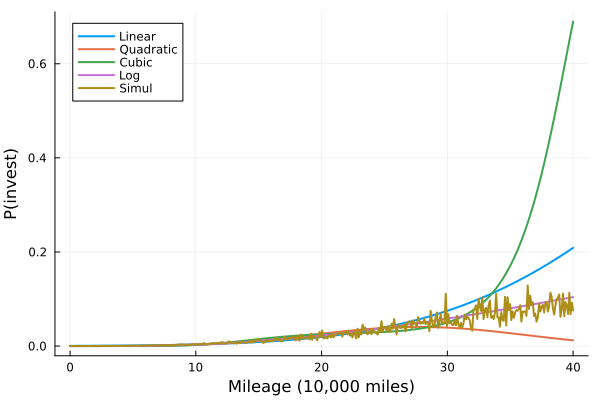

In [17]:

# Replacement today (scalar values)
x1_0start, x2_0start, x3_0start = x(0, true)

x1_1 = -1 + x1_0start
x2_1 = x2_0start
x3_1 = x3_0start

β1 = results.estimate[1]
β2 = results.estimate[2]

function simul_s_prob(s_grid)

    S = length(s_grid)

    x1_i0 = zeros(S)
    x2_i0 = zeros(S)
    x3_i0 = zeros(S)

    v1 = zeros(S)
    v2 = zeros(S)
    v3 = zeros(S)

    for i in 1:S
        s_i = s_grid[i]
        x1_i0[i], x2_i0[i], x3_i0[i] = x(s_i, false)

        v1[i] = x1_1 - x1_i0[i]
        v2[i] = x2_1 - x2_i0[i]
        v3[i] = x3_1 - x3_i0[i]
    end 

    eta = β1 .* v1 .+ β2 .* v2 .+ v3 
    prob = 1 ./(1 .+ exp.(-eta))

    return prob
end

grid_s = collect(range(0, 40, length=400))

prob_s= simul_s_prob(grid_s)


plot(grid, η1, label="Linear", xlabel="Mileage (10,000 miles)", ylabel="P(invest)", linewidth=2)
plot!(grid, η2, label="Quadratic", linewidth=2)
plot!(grid, η3, label="Cubic", linewidth=2)
plot!(grid, η4, label="Log", linewidth=2)
plot!(grid, prob_s, label="Simul", linewidth=2)

#savefig(joinpath(export_dir, "ps2_probit_probabilities.pdf")), w/1000 simul
